# Computer Vision - Fast Nearest Neighbors Algorithms

Author: `Vladislav Belov`

Date: `2020-03`
___

## Preparation of the Environment and Testing of PyFLANN

This section is dedicated to basic needs for reproducibility of results. Here we set up the Anaconda environment (note that the following code is functional also for standard Python installations; however, usage of virtual environments is recommended). We also test the functionality of PyFLANN by construction of a k-NN graph for synthetic data.

In [ ]:
# Installations (assuming that the notebook has been started under a fresh Anaconda virtual environment)
!conda install pip
!pip install 2to3 numpy pyflann scipy matplotlib networkx scikit-learn seaborn pandas

In [ ]:
# PyFLANN is a Python 2 package. We use Python 3.8.2; therefore, the package needs to be translated into Python 3.
# Following lines of code provide one with the path to Python packages folder.
# Use your path to PyFLANN library to translate it into Python 3.

# from distutils.sysconfig import get_python_lib
# print(get_python_lib())

!2to3 -w /Users/salisare-sama/opt/anaconda3/envs/computer-vision/lib/python3.8/site-packages/pyflann

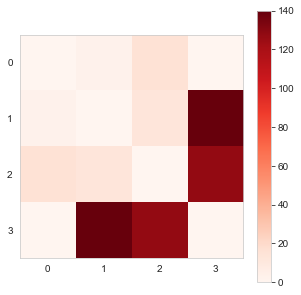

In [14]:
# Test PyFLANN by construction of a simple k-NN graph on synthetic data
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from pyflann import *


params = {
    'kdtree': {
        'algorithm': 'kdtree',
        'target_precision': .95,
        'trees': 32
    },
    'kmeans': {
        'algorithm': 'kmeans',
        'branching': 32,
        'iterations': 10,
        'target_precision': .95
    }
}
data = np.array([
    [-1., -1.],
    [1., 1.], 
    [10., 10.], 
    [100., 100.]
])

flann = FLANN()
neighbors, distances = flann.nn(
    data, data, num_neighbors=3, **params['kmeans'])

knn_graph = csr_matrix((np.sqrt(distances.ravel()), 
                        (
                            np.repeat(np.arange(neighbors.shape[0]), 
                                      repeats=neighbors.shape[1]).astype(np.int), 
                            neighbors.ravel().astype(np.int)
                        )
                       ))

# Plot the adjacency matrix
G = nx.from_numpy_array(knn_graph.toarray())
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pos = ax.imshow(nx.adjacency_matrix(G).toarray(), cmap='Reds', interpolation='none')
fig.colorbar(pos, ax=ax)
ax.set_xticks(np.arange(knn_graph.shape[1], dtype=np.int))
ax.set_yticks(np.arange(knn_graph.shape[0], dtype=np.int))
ax.grid(which='major')
plt.show()

## Data Download

In [ ]:
# Create directories to store data
from pathlib import Path

path = Path('./data/Oxford5K/').resolve()
path.mkdir(parents=True, exist_ok=True)
path = Path('./data/SIFT/').resolve()
path.mkdir(parents=True, exist_ok=True)

# Download raw data
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagenames.txt --output data/Oxford5K/imagenames.txt
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagedesc.dat --output data/Oxford5K/imagedesc.dat
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/images.zip --output data/Oxford5K/images.zip
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/sift.zip --output data/SIFT/sift.zip
!tar -xf data/Oxford5K/images.zip -C data/Oxford5K/
!tar -xf data/SIFT/sift.zip -C data/SIFT/

## Custom $k$-means Implementation

#### The Implementation

In the comments below, we also explain the meaning of pre-set PyFLANN parameters.

Vectors representing initial cluster centers are hard-coded using sampling from the uniform distribution $U(\alpha, \beta)$ where $\alpha$ and $\beta$ are given by values in the data set (minimum and maximum, respectively). This is only one of many solutions - more optimal ones are available, e.g. $k$-means++.


In [8]:
import numpy as np
from typing import Optional
from scipy.spatial.distance import cdist
from time import time
from pyflann import FLANN
from datetime import datetime
from pathlib import Path


class CustomKMeans(object):
    
    def __init__(self, 
                 n_centers: int = 2,
                 method: str = 'kmeans',
                 max_iter: int = 30,
                 max_iter_no_progress: int = 10, 
                 tol_progress: np.float = 1e-3, 
                 random_state: Optional[int] = 17,
                 nn_km_branching: int = 32,  # branching for k-means tree
                 nn_km_iter: int = 20, # number of iterations per k-means step
                 nn_kd_trees: int = 32,  # number of randomized trees to use
                 nn_checks: int = 75,  # number of leaves to check in the search
                 nn_autotune: np.float = -1,  # auto-tuning of nn parameters
                 save_log: bool = True,
                 verbose: bool = False):
        
        assert method in {'kmeans', 'kdtree', 'exact'}
        
        # FLANN hyperparameters
        # The whole list of FLANN parameters is available here:
        # https://github.com/mariusmuja/flann/blob/master/src/cpp/flann/flann.h
        self.flann = None
        self.params = {
            'kdtree': {
                'algorithm': 'kdtree',
                'num_neighbors': 1,
                'trees': nn_kd_trees, 
                'checks': nn_checks,
                'target_precision': nn_autotune
            },
            'kmeans': {
                'algorithm': 'kmeans',
                'num_neighbors': 1,
                'branching': nn_km_branching,  
                'iterations': nn_km_iter, 
                'checks': nn_checks,
                'target_precision': nn_autotune
            },
            'exact':
            {
                'algorithm': 'exact'
            }
        }
        
        # Set target precision in case of autotuning
        if method in {'kmeans', 'kdtree'}:
            self.flann = FLANN()
        
        self.n_centers = n_centers
        self.method = method
        self.max_iter = max_iter
        self.max_iter_no_progress = max_iter_no_progress
        self.tol_progress = tol_progress
        self.random_state = random_state
        self.verbose = verbose
        
        self._dim = None
        self._n_samples = None
        self.centers_ = None
        self.labels_ = None
        self.stats_ = None
        self.session_id = f'n_centers_{self.n_centers}-' + \
            '-'.join(
            [f'{param}_{val}' for param, val 
             in self.params[self.method].items()]
        )
        self.log_ = []
        self.save_log = save_log
        
    def __reset_stats(self):
        self.stats_ = {
            'measure': [],  # the cost function
            'evaluation': [],  # time to evaluate labels
            'assignment': [],  # time to re-assign labels
            'n_centers': self.n_centers,
            **self.params[self.method]
        }
    
    def __update_stats(self, 
                       measure: np.float, 
                       time_eval: np.float, 
                       time_assign: np.float):
        self.stats_['measure'].append(measure)
        self.stats_['evaluation'].append(time_eval)
        self.stats_['assignment'].append(time_assign)
        
    def fit(self, data: np.ndarray) -> None:
        self._n_samples, self._dim = data.shape
        
        np.random.seed(self.random_state)
        
        # Initialize centers (we use uniform random initialization)
        self.centers_ = np.random.uniform(
            np.min(data), np.max(data), 
            size=self.n_centers * self._dim
        ).reshape(self.n_centers, self._dim).astype(data.dtype)
        
        # Start fitting
        self.__reset_stats()
        self.log_.append(
            f'Session id: {self.session_id} '
            f'at {datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")}'
        )
        progress = self.max_iter_no_progress
        for it in range(self.max_iter):
            
            tic_it = time()

            # Evaluate labels and squared distances
            if self.method in {'kmeans', 'kdtree'}:
                self.labels_, sqdist = self.flann.nn(
                    self.centers_, data, **self.params[self.method])
            else:
                self.labels_ = np.ndarray((self._n_samples,), dtype=np.int)
                sqdist = np.ndarray((self._n_samples,))
                for p in range(self._n_samples):
                    if self.verbose and (_aux := p + 1) % 100 == 0:
                        print(f'\t\tExact approach: point {_aux} out of {self._n_samples}')
                    sqpdist = cdist(data[p].reshape(1, -1), self.centers_, 
                                    metric='sqeuclidean')
                    self.labels_[p] = sqpdist.argmin(axis=1)[0]
                    sqdist[p] = sqpdist[0, self.labels_[p]]
                # Vectrorised approach
                # sqpdist = cdist(data, self.centers_, metric='sqeuclidean')
                # self.labels_ = sqpdist.argmin(axis=1)
                # sqdist = sqpdist[np.arange(self._n_samples), self.labels_]
            toc = time()
            t1 = toc - tic_it
            
            # Update centers
            tic = time()
            for label in range(self.n_centers):
                idx = np.where(self.labels_ == label)[0]
                if len(idx):
                    self.centers_[label] = data[idx].mean(axis=0)
                else:
                    # If the cluster is empty, move its center anyway
                    self.centers_[label] = self.centers_.mean(axis=0)
            toc_it = time()
            t2 = toc_it - tic
            
            # Print progress
            self.log_.append(
                f'\t--> iteration {it} '
                f'has been finished -- {toc_it - tic_it:.3e}s'
            )
            if self.verbose:
                print(self.log_[-1])
                    
            # Check convergence
            p = np.bincount(self.labels_, weights=sqdist).sum() / data.shape[0]
            if it > 1 and self.stats_['measure'][-2] - \
                    self.stats_['measure'][-1] < self.tol_progress:
                progress -= 1
                if not progress:
                    self.__update_stats(p, t1, t2)
                    print(f'\nIteration {it}: '
                          f'no progress during '
                          f'last {self.max_iter_no_progress} iterations')
                    break
            else:
                self.__update_stats(p, t1, t2)
                progress = self.max_iter_no_progress
        
        # Save the log
        self.log_.append(self.time_report())
        if self.save_log:
            path = Path(f'./logs/{self.__class__.__name__}/').resolve()
            path.mkdir(parents=True, exist_ok=True)
            with open(f'{str(path)}/{self.session_id}.txt', 'w') as file:
                for line in self.log_:
                    file.write(f'{line}\n')
        
    def fit_predict(self, data: np.ndarray) -> np.ndarray:
        
        self.fit(data)
        
        return self.labels_
    
    def time_report(self) -> str:
        if self.stats_ is None:
            rep = 'No statistics are available.'
        else:
            t_eval = np.asarray(self.stats_['evaluation'])
            t_assign = np.asarray(self.stats_['assignment'])
            rep = f'\nEvaluation time per iteration:\n\tAVG. = {t_eval.mean()}s\n\tSTD. = {t_eval.std()}s\nAssignment time per iteration:\n\tAVG. = {t_assign.mean()}s\n\tSTD. = {t_assign.std()}s'
        return rep


#### Test of the Implementation

To test the implementation, we apply `CustomKMeans` on randomly generated blobs and plot results.


Iteration 20: no progress during last 10 iterations

Evaluation time per iteration:
	AVG. = 0.00016979376475016275s
	STD. = 0.0003797443660041656s
Assignment time per iteration:
	AVG. = 0.000249942143758138s
	STD. = 0.00043291273631423466s


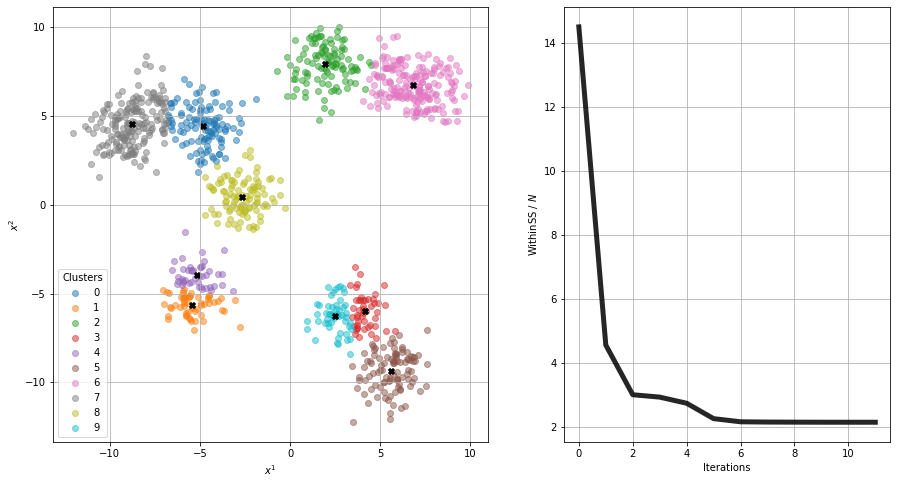

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs


# Generate random data
np.random.seed(17)
N_CENTERS = 10
N_SAMPLES = 1000
DIM = 2
data, _ = make_blobs(
    n_samples=N_SAMPLES, 
    centers=N_CENTERS, 
    n_features=DIM,
    random_state=20
)
# data = np.random.random((N_SAMPLES, DIM)).astype(np.float32)

# Fit using CustomKMeans
km = CustomKMeans(
    n_centers=N_CENTERS, 
    method='exact',
    nn_autotune=-1,
    verbose=False
)
km.fit(data)
print(km.time_report())
centers = km.centers_
labels = km.labels_
measure = km.stats_['measure']

# Plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8),
                              gridspec_kw={'width_ratios': (2, 1.5)})
for label in range(N_CENTERS):
    idx = np.where(labels == label)[0]
    ax1.scatter(data[idx, 0], data[idx, 1], label=label, alpha=.5)
    ax1.scatter(centers[label, 0], centers[label, 1], marker='X', s=35, color='k')
ax1.set_xlabel(r'$x^{1}$')
ax1.set_ylabel(r'$x^{2}$')
ax1.legend(loc='best', title='Clusters')
ax2.plot(np.arange(len(measure)), measure, color='k', linewidth=5., alpha=.85)
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'WithinSS / $N$')
ax1.grid(True)
ax2.grid(True)
fig.savefig('./images/flann/kmeans_test.png')
plt.show()

## Comparison of NN Approaches in the Approximate $k$-means Framework

In following sections we apply `CustomKMeans` on the SIFT 2M data set using three different methods to assign points to respective cluster centers:

  * k-d tree forest;
  * priority search $k$-means tree;
  * exact assignment.

For each method, we calculate time spent on calculation per iteration and print it. Visual comparison of impact of observed approaches on cost function $\Phi(X) = \frac{1}{N}\sum_{i = 1}^{N} \lVert X_{i} - f(X_{i})\rVert_{2}^{2}$ follows in the next section (we also use "WithinSS / $N$" to denote $\Phi(X)$ on figures).

*Notation*:
  * $X \in \mathbb{R}^{N \times d}$ where $N$ is the number of samples and $d$ is the dimension;
  * $X_{i}$, $i \in \{1, 2, \dots, N\}$, is the $i$-th row of matrix $X$;
  * $\lVert \cdot \rVert_{2}$ is the Euclidean norm $\left( \lVert \cdot \rVert_{2} = \sqrt{\left< \cdot, \cdot \right>} \right)$.

#### Evaluation

We fit $32$K cluster centers.

In [3]:
# Load data
import numpy as np
import re


# Oxford5K data
if 0:
    # Process image names
    img_names = []
    with open('./data/Oxford5K/imagenames.txt', mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            img_names.append(re.sub(r'\n', '', line))
    print(f'Found {len(img_names)} image names: {img_names[:3]}')

    # Process descriptors
    X = np.fromfile('./data/Oxford5K/imagedesc.dat', dtype=np.float32)
    X = X.reshape((len(img_names), -1))
    print(f'Descriptors format: {X.shape}')
    
# SIFT data
else:
    # Reading the SIFT data set
    X = np.fromfile('./data/SIFT/SIFT.dat', dtype=np.uint8).astype(np.float32)
    X = X.reshape((-1, 128))
    print(f'Descriptors format: {X.shape}')

Descriptors format: (2097152, 128)


In [ ]:
# Evaluate
import pandas as pd

METHOD = 'exact'
print(f'Method: {METHOD}')
km = CustomKMeans(
    n_centers=32000, 
    method=METHOD,
    nn_autotune=-1,
    nn_checks=75,
    nn_kd_trees=32,
    nn_km_branching=32,
    nn_km_iter=20,
    verbose=True
)
km.fit(X)
print(km.time_report())
df = pd.DataFrame(km.stats_)
df = df.reset_index(drop=False)
df.to_csv(f'./data/sift_comparison_{km.session_id}.csv', index=False)

Method: exact
		Exact approach: point 100 out of 2097152
		Exact approach: point 200 out of 2097152
		Exact approach: point 300 out of 2097152
		Exact approach: point 400 out of 2097152
		Exact approach: point 500 out of 2097152
		Exact approach: point 600 out of 2097152
		Exact approach: point 700 out of 2097152
		Exact approach: point 800 out of 2097152
		Exact approach: point 900 out of 2097152
		Exact approach: point 1000 out of 2097152
		Exact approach: point 1100 out of 2097152
		Exact approach: point 1200 out of 2097152
		Exact approach: point 1300 out of 2097152
		Exact approach: point 1400 out of 2097152
		Exact approach: point 1500 out of 2097152
		Exact approach: point 1600 out of 2097152
		Exact approach: point 1700 out of 2097152
		Exact approach: point 1800 out of 2097152
		Exact approach: point 1900 out of 2097152
		Exact approach: point 2000 out of 2097152
		Exact approach: point 2100 out of 2097152
		Exact approach: point 2200 out of 2097152
		Exact approach: point 230

		Exact approach: point 18600 out of 2097152
		Exact approach: point 18700 out of 2097152
		Exact approach: point 18800 out of 2097152
		Exact approach: point 18900 out of 2097152
		Exact approach: point 19000 out of 2097152
		Exact approach: point 19100 out of 2097152
		Exact approach: point 19200 out of 2097152
		Exact approach: point 19300 out of 2097152
		Exact approach: point 19400 out of 2097152
		Exact approach: point 19500 out of 2097152
		Exact approach: point 19600 out of 2097152
		Exact approach: point 19700 out of 2097152
		Exact approach: point 19800 out of 2097152
		Exact approach: point 19900 out of 2097152
		Exact approach: point 20000 out of 2097152
		Exact approach: point 20100 out of 2097152
		Exact approach: point 20200 out of 2097152
		Exact approach: point 20300 out of 2097152
		Exact approach: point 20400 out of 2097152
		Exact approach: point 20500 out of 2097152
		Exact approach: point 20600 out of 2097152
		Exact approach: point 20700 out of 2097152
		Exact ap

		Exact approach: point 36900 out of 2097152
		Exact approach: point 37000 out of 2097152
		Exact approach: point 37100 out of 2097152
		Exact approach: point 37200 out of 2097152
		Exact approach: point 37300 out of 2097152
		Exact approach: point 37400 out of 2097152
		Exact approach: point 37500 out of 2097152
		Exact approach: point 37600 out of 2097152
		Exact approach: point 37700 out of 2097152
		Exact approach: point 37800 out of 2097152
		Exact approach: point 37900 out of 2097152
		Exact approach: point 38000 out of 2097152
		Exact approach: point 38100 out of 2097152
		Exact approach: point 38200 out of 2097152
		Exact approach: point 38300 out of 2097152
		Exact approach: point 38400 out of 2097152
		Exact approach: point 38500 out of 2097152
		Exact approach: point 38600 out of 2097152
		Exact approach: point 38700 out of 2097152
		Exact approach: point 38800 out of 2097152
		Exact approach: point 38900 out of 2097152
		Exact approach: point 39000 out of 2097152
		Exact ap

		Exact approach: point 55200 out of 2097152
		Exact approach: point 55300 out of 2097152
		Exact approach: point 55400 out of 2097152
		Exact approach: point 55500 out of 2097152
		Exact approach: point 55600 out of 2097152
		Exact approach: point 55700 out of 2097152
		Exact approach: point 55800 out of 2097152
		Exact approach: point 55900 out of 2097152
		Exact approach: point 56000 out of 2097152
		Exact approach: point 56100 out of 2097152
		Exact approach: point 56200 out of 2097152
		Exact approach: point 56300 out of 2097152
		Exact approach: point 56400 out of 2097152
		Exact approach: point 56500 out of 2097152
		Exact approach: point 56600 out of 2097152
		Exact approach: point 56700 out of 2097152
		Exact approach: point 56800 out of 2097152
		Exact approach: point 56900 out of 2097152
		Exact approach: point 57000 out of 2097152
		Exact approach: point 57100 out of 2097152
		Exact approach: point 57200 out of 2097152
		Exact approach: point 57300 out of 2097152
		Exact ap

		Exact approach: point 73500 out of 2097152
		Exact approach: point 73600 out of 2097152
		Exact approach: point 73700 out of 2097152
		Exact approach: point 73800 out of 2097152
		Exact approach: point 73900 out of 2097152
		Exact approach: point 74000 out of 2097152
		Exact approach: point 74100 out of 2097152
		Exact approach: point 74200 out of 2097152
		Exact approach: point 74300 out of 2097152
		Exact approach: point 74400 out of 2097152
		Exact approach: point 74500 out of 2097152
		Exact approach: point 74600 out of 2097152
		Exact approach: point 74700 out of 2097152
		Exact approach: point 74800 out of 2097152
		Exact approach: point 74900 out of 2097152
		Exact approach: point 75000 out of 2097152
		Exact approach: point 75100 out of 2097152
		Exact approach: point 75200 out of 2097152
		Exact approach: point 75300 out of 2097152
		Exact approach: point 75400 out of 2097152
		Exact approach: point 75500 out of 2097152
		Exact approach: point 75600 out of 2097152
		Exact ap

		Exact approach: point 91800 out of 2097152
		Exact approach: point 91900 out of 2097152
		Exact approach: point 92000 out of 2097152
		Exact approach: point 92100 out of 2097152
		Exact approach: point 92200 out of 2097152
		Exact approach: point 92300 out of 2097152
		Exact approach: point 92400 out of 2097152
		Exact approach: point 92500 out of 2097152
		Exact approach: point 92600 out of 2097152
		Exact approach: point 92700 out of 2097152
		Exact approach: point 92800 out of 2097152
		Exact approach: point 92900 out of 2097152
		Exact approach: point 93000 out of 2097152
		Exact approach: point 93100 out of 2097152
		Exact approach: point 93200 out of 2097152
		Exact approach: point 93300 out of 2097152
		Exact approach: point 93400 out of 2097152
		Exact approach: point 93500 out of 2097152
		Exact approach: point 93600 out of 2097152
		Exact approach: point 93700 out of 2097152
		Exact approach: point 93800 out of 2097152
		Exact approach: point 93900 out of 2097152
		Exact ap

		Exact approach: point 109800 out of 2097152
		Exact approach: point 109900 out of 2097152
		Exact approach: point 110000 out of 2097152
		Exact approach: point 110100 out of 2097152
		Exact approach: point 110200 out of 2097152
		Exact approach: point 110300 out of 2097152
		Exact approach: point 110400 out of 2097152
		Exact approach: point 110500 out of 2097152
		Exact approach: point 110600 out of 2097152
		Exact approach: point 110700 out of 2097152
		Exact approach: point 110800 out of 2097152
		Exact approach: point 110900 out of 2097152
		Exact approach: point 111000 out of 2097152
		Exact approach: point 111100 out of 2097152
		Exact approach: point 111200 out of 2097152
		Exact approach: point 111300 out of 2097152
		Exact approach: point 111400 out of 2097152
		Exact approach: point 111500 out of 2097152
		Exact approach: point 111600 out of 2097152
		Exact approach: point 111700 out of 2097152
		Exact approach: point 111800 out of 2097152
		Exact approach: point 111900 out

		Exact approach: point 127700 out of 2097152
		Exact approach: point 127800 out of 2097152
		Exact approach: point 127900 out of 2097152
		Exact approach: point 128000 out of 2097152
		Exact approach: point 128100 out of 2097152
		Exact approach: point 128200 out of 2097152
		Exact approach: point 128300 out of 2097152
		Exact approach: point 128400 out of 2097152
		Exact approach: point 128500 out of 2097152
		Exact approach: point 128600 out of 2097152
		Exact approach: point 128700 out of 2097152
		Exact approach: point 128800 out of 2097152
		Exact approach: point 128900 out of 2097152
		Exact approach: point 129000 out of 2097152
		Exact approach: point 129100 out of 2097152
		Exact approach: point 129200 out of 2097152
		Exact approach: point 129300 out of 2097152
		Exact approach: point 129400 out of 2097152
		Exact approach: point 129500 out of 2097152
		Exact approach: point 129600 out of 2097152
		Exact approach: point 129700 out of 2097152
		Exact approach: point 129800 out

		Exact approach: point 145600 out of 2097152
		Exact approach: point 145700 out of 2097152
		Exact approach: point 145800 out of 2097152
		Exact approach: point 145900 out of 2097152
		Exact approach: point 146000 out of 2097152
		Exact approach: point 146100 out of 2097152
		Exact approach: point 146200 out of 2097152
		Exact approach: point 146300 out of 2097152
		Exact approach: point 146400 out of 2097152
		Exact approach: point 146500 out of 2097152
		Exact approach: point 146600 out of 2097152
		Exact approach: point 146700 out of 2097152
		Exact approach: point 146800 out of 2097152
		Exact approach: point 146900 out of 2097152
		Exact approach: point 147000 out of 2097152
		Exact approach: point 147100 out of 2097152
		Exact approach: point 147200 out of 2097152
		Exact approach: point 147300 out of 2097152
		Exact approach: point 147400 out of 2097152
		Exact approach: point 147500 out of 2097152
		Exact approach: point 147600 out of 2097152
		Exact approach: point 147700 out

		Exact approach: point 163500 out of 2097152
		Exact approach: point 163600 out of 2097152
		Exact approach: point 163700 out of 2097152
		Exact approach: point 163800 out of 2097152
		Exact approach: point 163900 out of 2097152
		Exact approach: point 164000 out of 2097152
		Exact approach: point 164100 out of 2097152
		Exact approach: point 164200 out of 2097152
		Exact approach: point 164300 out of 2097152
		Exact approach: point 164400 out of 2097152
		Exact approach: point 164500 out of 2097152
		Exact approach: point 164600 out of 2097152
		Exact approach: point 164700 out of 2097152
		Exact approach: point 164800 out of 2097152
		Exact approach: point 164900 out of 2097152
		Exact approach: point 165000 out of 2097152
		Exact approach: point 165100 out of 2097152
		Exact approach: point 165200 out of 2097152
		Exact approach: point 165300 out of 2097152
		Exact approach: point 165400 out of 2097152
		Exact approach: point 165500 out of 2097152
		Exact approach: point 165600 out

		Exact approach: point 181400 out of 2097152
		Exact approach: point 181500 out of 2097152
		Exact approach: point 181600 out of 2097152
		Exact approach: point 181700 out of 2097152
		Exact approach: point 181800 out of 2097152
		Exact approach: point 181900 out of 2097152
		Exact approach: point 182000 out of 2097152
		Exact approach: point 182100 out of 2097152
		Exact approach: point 182200 out of 2097152
		Exact approach: point 182300 out of 2097152
		Exact approach: point 182400 out of 2097152
		Exact approach: point 182500 out of 2097152
		Exact approach: point 182600 out of 2097152
		Exact approach: point 182700 out of 2097152
		Exact approach: point 182800 out of 2097152
		Exact approach: point 182900 out of 2097152
		Exact approach: point 183000 out of 2097152
		Exact approach: point 183100 out of 2097152
		Exact approach: point 183200 out of 2097152
		Exact approach: point 183300 out of 2097152
		Exact approach: point 183400 out of 2097152
		Exact approach: point 183500 out

		Exact approach: point 199300 out of 2097152
		Exact approach: point 199400 out of 2097152
		Exact approach: point 199500 out of 2097152
		Exact approach: point 199600 out of 2097152
		Exact approach: point 199700 out of 2097152
		Exact approach: point 199800 out of 2097152
		Exact approach: point 199900 out of 2097152
		Exact approach: point 200000 out of 2097152
		Exact approach: point 200100 out of 2097152
		Exact approach: point 200200 out of 2097152
		Exact approach: point 200300 out of 2097152
		Exact approach: point 200400 out of 2097152
		Exact approach: point 200500 out of 2097152
		Exact approach: point 200600 out of 2097152
		Exact approach: point 200700 out of 2097152
		Exact approach: point 200800 out of 2097152
		Exact approach: point 200900 out of 2097152
		Exact approach: point 201000 out of 2097152
		Exact approach: point 201100 out of 2097152
		Exact approach: point 201200 out of 2097152
		Exact approach: point 201300 out of 2097152
		Exact approach: point 201400 out

		Exact approach: point 217200 out of 2097152
		Exact approach: point 217300 out of 2097152
		Exact approach: point 217400 out of 2097152
		Exact approach: point 217500 out of 2097152
		Exact approach: point 217600 out of 2097152
		Exact approach: point 217700 out of 2097152
		Exact approach: point 217800 out of 2097152
		Exact approach: point 217900 out of 2097152
		Exact approach: point 218000 out of 2097152
		Exact approach: point 218100 out of 2097152
		Exact approach: point 218200 out of 2097152
		Exact approach: point 218300 out of 2097152
		Exact approach: point 218400 out of 2097152
		Exact approach: point 218500 out of 2097152
		Exact approach: point 218600 out of 2097152
		Exact approach: point 218700 out of 2097152
		Exact approach: point 218800 out of 2097152
		Exact approach: point 218900 out of 2097152
		Exact approach: point 219000 out of 2097152
		Exact approach: point 219100 out of 2097152
		Exact approach: point 219200 out of 2097152
		Exact approach: point 219300 out

		Exact approach: point 235100 out of 2097152
		Exact approach: point 235200 out of 2097152
		Exact approach: point 235300 out of 2097152
		Exact approach: point 235400 out of 2097152
		Exact approach: point 235500 out of 2097152
		Exact approach: point 235600 out of 2097152
		Exact approach: point 235700 out of 2097152
		Exact approach: point 235800 out of 2097152
		Exact approach: point 235900 out of 2097152
		Exact approach: point 236000 out of 2097152
		Exact approach: point 236100 out of 2097152
		Exact approach: point 236200 out of 2097152
		Exact approach: point 236300 out of 2097152
		Exact approach: point 236400 out of 2097152
		Exact approach: point 236500 out of 2097152
		Exact approach: point 236600 out of 2097152
		Exact approach: point 236700 out of 2097152
		Exact approach: point 236800 out of 2097152
		Exact approach: point 236900 out of 2097152
		Exact approach: point 237000 out of 2097152
		Exact approach: point 237100 out of 2097152
		Exact approach: point 237200 out

		Exact approach: point 253000 out of 2097152
		Exact approach: point 253100 out of 2097152
		Exact approach: point 253200 out of 2097152
		Exact approach: point 253300 out of 2097152
		Exact approach: point 253400 out of 2097152
		Exact approach: point 253500 out of 2097152
		Exact approach: point 253600 out of 2097152
		Exact approach: point 253700 out of 2097152
		Exact approach: point 253800 out of 2097152
		Exact approach: point 253900 out of 2097152
		Exact approach: point 254000 out of 2097152
		Exact approach: point 254100 out of 2097152
		Exact approach: point 254200 out of 2097152
		Exact approach: point 254300 out of 2097152
		Exact approach: point 254400 out of 2097152
		Exact approach: point 254500 out of 2097152
		Exact approach: point 254600 out of 2097152
		Exact approach: point 254700 out of 2097152
		Exact approach: point 254800 out of 2097152
		Exact approach: point 254900 out of 2097152
		Exact approach: point 255000 out of 2097152
		Exact approach: point 255100 out

		Exact approach: point 270900 out of 2097152
		Exact approach: point 271000 out of 2097152
		Exact approach: point 271100 out of 2097152
		Exact approach: point 271200 out of 2097152
		Exact approach: point 271300 out of 2097152
		Exact approach: point 271400 out of 2097152
		Exact approach: point 271500 out of 2097152
		Exact approach: point 271600 out of 2097152
		Exact approach: point 271700 out of 2097152
		Exact approach: point 271800 out of 2097152
		Exact approach: point 271900 out of 2097152
		Exact approach: point 272000 out of 2097152
		Exact approach: point 272100 out of 2097152
		Exact approach: point 272200 out of 2097152
		Exact approach: point 272300 out of 2097152
		Exact approach: point 272400 out of 2097152
		Exact approach: point 272500 out of 2097152
		Exact approach: point 272600 out of 2097152
		Exact approach: point 272700 out of 2097152
		Exact approach: point 272800 out of 2097152
		Exact approach: point 272900 out of 2097152
		Exact approach: point 273000 out

		Exact approach: point 288800 out of 2097152
		Exact approach: point 288900 out of 2097152
		Exact approach: point 289000 out of 2097152
		Exact approach: point 289100 out of 2097152
		Exact approach: point 289200 out of 2097152
		Exact approach: point 289300 out of 2097152
		Exact approach: point 289400 out of 2097152
		Exact approach: point 289500 out of 2097152
		Exact approach: point 289600 out of 2097152
		Exact approach: point 289700 out of 2097152
		Exact approach: point 289800 out of 2097152
		Exact approach: point 289900 out of 2097152
		Exact approach: point 290000 out of 2097152
		Exact approach: point 290100 out of 2097152
		Exact approach: point 290200 out of 2097152
		Exact approach: point 290300 out of 2097152
		Exact approach: point 290400 out of 2097152
		Exact approach: point 290500 out of 2097152
		Exact approach: point 290600 out of 2097152
		Exact approach: point 290700 out of 2097152
		Exact approach: point 290800 out of 2097152
		Exact approach: point 290900 out

		Exact approach: point 306700 out of 2097152
		Exact approach: point 306800 out of 2097152
		Exact approach: point 306900 out of 2097152
		Exact approach: point 307000 out of 2097152
		Exact approach: point 307100 out of 2097152
		Exact approach: point 307200 out of 2097152
		Exact approach: point 307300 out of 2097152
		Exact approach: point 307400 out of 2097152
		Exact approach: point 307500 out of 2097152
		Exact approach: point 307600 out of 2097152
		Exact approach: point 307700 out of 2097152
		Exact approach: point 307800 out of 2097152
		Exact approach: point 307900 out of 2097152
		Exact approach: point 308000 out of 2097152
		Exact approach: point 308100 out of 2097152
		Exact approach: point 308200 out of 2097152
		Exact approach: point 308300 out of 2097152
		Exact approach: point 308400 out of 2097152
		Exact approach: point 308500 out of 2097152
		Exact approach: point 308600 out of 2097152
		Exact approach: point 308700 out of 2097152
		Exact approach: point 308800 out

		Exact approach: point 324600 out of 2097152
		Exact approach: point 324700 out of 2097152
		Exact approach: point 324800 out of 2097152
		Exact approach: point 324900 out of 2097152
		Exact approach: point 325000 out of 2097152
		Exact approach: point 325100 out of 2097152
		Exact approach: point 325200 out of 2097152
		Exact approach: point 325300 out of 2097152
		Exact approach: point 325400 out of 2097152
		Exact approach: point 325500 out of 2097152
		Exact approach: point 325600 out of 2097152
		Exact approach: point 325700 out of 2097152
		Exact approach: point 325800 out of 2097152
		Exact approach: point 325900 out of 2097152
		Exact approach: point 326000 out of 2097152
		Exact approach: point 326100 out of 2097152
		Exact approach: point 326200 out of 2097152
		Exact approach: point 326300 out of 2097152
		Exact approach: point 326400 out of 2097152
		Exact approach: point 326500 out of 2097152
		Exact approach: point 326600 out of 2097152
		Exact approach: point 326700 out

For the current number of centers, the exact approach is still faster that the kd-tree-based one. Nonetheless, during our expirements, we have confirmed that the latter technique outperforms exact assignment in speed.

We also wish to point out that the current implementation of the exact approach performs vector operations and works with large matrices. This method is fast and efficient for smaller data sets; however, for $N \approx 2$M, each iteration demanded a lot of memory:
![alt text](images/flann/poor_ram.png "RAM usage during the exact evaluation")

#### Comparison Figure

From the figure below, one can conclude that for the given number of cluster centers and for the set parameters all methods converge in a similar manner. 

An interesting observation is that during iterations $5$ and $10$ the evaluation quality of the kd-tree-based approach is better than the exact assignment. However, Euclidean distance is quite sensitive in high-dimensional spaces. Thereofore, we consider this difference negligible. Another factor that could have influenced the situation is that our naive implementation of $k$-means accounts for empty clusters and attempts to move their centers.

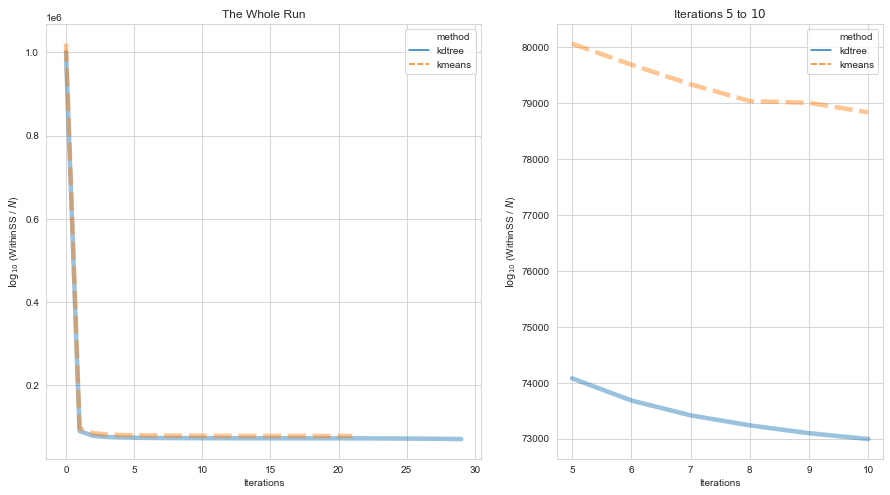

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("whitegrid")


df = pd.read_csv('./data/sift_comparison_32000_auto-1_75_32.csv')
# df.loc[:, 'measure'] = np.log10(df.loc[:, 'measure'])

# Plot results
order = sorted(np.unique(df['method']))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), 
                               gridspec_kw={'width_ratios': (2, 1.5)})
sns.lineplot(x='index', y='measure', 
             hue='method', style='method', alpha=.45,
             hue_order=order,
             style_order=order,
             linewidth=4.5,
             ax=ax1, 
             data=df)
ax1.set_xlabel('Iterations')
ax1.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
ax1.set_title('The Whole Run')
sns.lineplot(x='index', y='measure', 
             hue='method', style='method', alpha=.45,
             hue_order=order,
             style_order=order,
             linewidth=4.5,
             ax=ax2, 
             data=df[(df['index'] <= 10) & (df['index'] >= 5)])
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
ax2.set_title('Iterations $5$ to $10$')
fig.savefig('./images/flann/comparison.png')
plt.show()